In [131]:
## import libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, butter, sosfiltfilt
import tkinter as tk
from tkinter import filedialog
import csv
import os
from scipy.io.wavfile import write

In [132]:
## functions
# get file path of desired file to be analyzed
def open_file_dialog():
    root = tk.Tk()
    root.withdraw() # hide main window
    root.call('wm', 'attributes', '.', '-topmost', True)
    file_path = filedialog.askopenfilename()
    print("Selected file: ", file_path)
    
    if not file_path:
        print("No file selected.")
        return

    try:
         with open(file_path, 'r') as f:
             content = f.read()
    except Exception as e:
         print(f"Failed to read file: {e}")
    
    return file_path

# bandpass filter
def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

# convert and array of values to audio file
def csv2mp3(audio,sample_rate,output_file="microphone_audio"):
    # Define the sampling rate (samples per second)
    samples = audio


    # Normalize the voltage values to fit into the range of int16 (-32768 to 32767)
    max_val = max(samples)
    min_val = min(samples)
    normalized_samples = np.array(
        [(value - min_val) / (max_val - min_val) * 2 - 1 for value in samples]
    )
    audio_data = (normalized_samples * 32767).astype(np.int16)

    # Save to a .wav file
    output_file = output_file + ".wav"
    write(output_file, sample_rate, audio_data)
    print(f"Audio file '{output_file}' has been created!")

# decode the log file from the SD card  
def decode_log(file:str):
    #Returns two arrays, time and values, takes in a string for the file path
    import struct
    def get_freq(timestamps):
        time_array = []
        for i in range(len(timestamps)):
            if (i+1)<len(timestamps):
                start_time = timestamps[i]
                end_time = timestamps[i+1]
                time_array.append(np.linspace(start_time,end_time,READING_COUNT))
            else:
                start_time = timestamps[i-1]
                end_time = timestamps[i]
                time_array.append(np.linspace(start_time,end_time,READING_COUNT))
        return time_array
        
    BLOCK_SIZE = 1024
    READING_COUNT = 510 # 1020 bytes/2
    timestamps = []
    readings = []
    with open(file, "rb") as f:
        while True:
            block = f.read(BLOCK_SIZE)
            if len(block) < BLOCK_SIZE:
                break  # Incomplete block at end of file

            # Timestamp is in the last 4 bytes
            timestamp = struct.unpack_from("<I", block, BLOCK_SIZE - 4)[0]
            timestamps.append(timestamp)

            # First 1020 bytes = 510 uint16 readings
            readings_block = struct.unpack_from("<" + "H" * READING_COUNT, block, 0)
            readings.append(readings_block)
    time_array = get_freq(timestamps)
    
    
    flat_time = [v for block in time_array for v in block]
    time = np.array(flat_time)/1000

    flat_values = [v for block in readings for v in block]
    values = np.array(flat_values)

    # check if time array is in increasing values, if not reverse both arrays
    if time[0] > time[1]:
        time = time[::-1]
        values = values[::-1]
    
    # zero the time array using the value at index 0 
    offset = time[0]
    time = np.array([(t - offset) for t in time])   
    
    d = np.diff(flat_time)
    freq = (np.average(d)/1000)**-1
    freq = int(abs(freq))
    return time,values,freq

# normalize array
def normalize_array(arr):
    norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return norm_arr

# identify and scale down outlying spikes
def remove_spikes(waveform, threshold, window_size):
    # Convert the waveform to a numpy array
    waveform = np.array(waveform)
    
    # Calculate the Z-scores of the waveform
    mean = np.mean(waveform)
    std = np.std(waveform)
    z_scores = (waveform - mean) / std
    
    # Create a copy of the waveform to modify
    cleaned_waveform = waveform.copy()
    
    # Loop through the waveform and check for outliers based on Z-score
    for i in range(1, len(waveform) - 1):
        if abs(z_scores[i]) > threshold:  # Check if current point is an outlier
            # Replace outlier with the average of its neighbors
            left = max(0, i - window_size)
            right = min(len(waveform), i + window_size + 1)
            cleaned_waveform[i] = np.mean(waveform[left:right])
    
    return cleaned_waveform

In [ ]:
## name for plot titles
# get user input for session name
name = input("input session name, press enter to skip and use file name: ")
print("Session name: ", name)

In [ ]:
## file selection
# get csv data file of heartbeat data
file_path = open_file_dialog()

# use file name if no name is specified
if not name:
    name = os.path.basename(file_path)

# extract time, values, and sample rate from file
time,values,sr = decode_log(file_path)

Selected file:  C:/Users/hsiao/Desktop/UBC/MECH4/MECH 457/post processing/Mar 31/Log19
Failed to read file: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte


Text(0.5, 1.0, 'Log19 raw data')

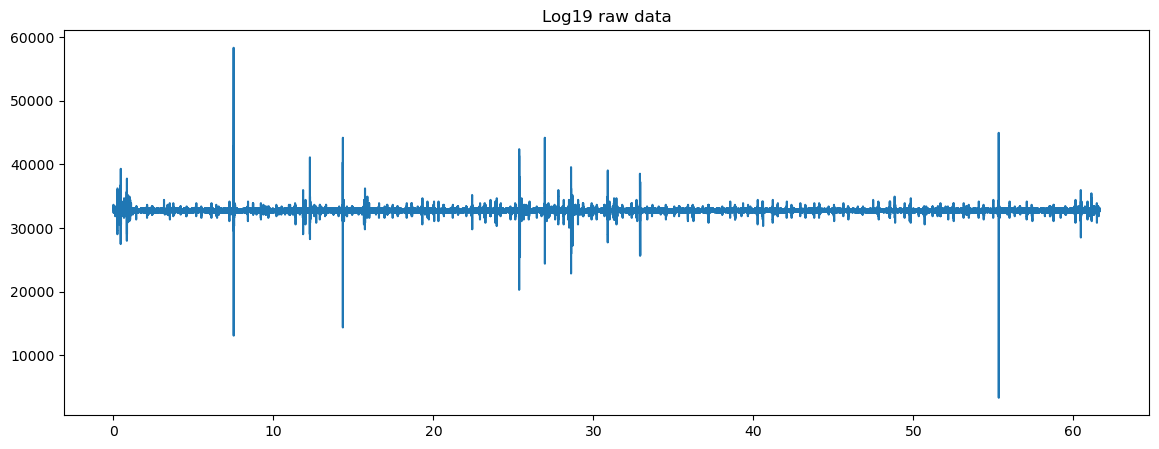

In [135]:
## raw data
# plot waveform
plt.figure(figsize=(14, 5))
plt.plot(time, values)
plt.title(f"{name} raw data")

In [ ]:
## convert raw data to wav
csv2mp3(values,sr,output_file=(name))

Text(0.5, 1.0, 'Log19 filtered data')

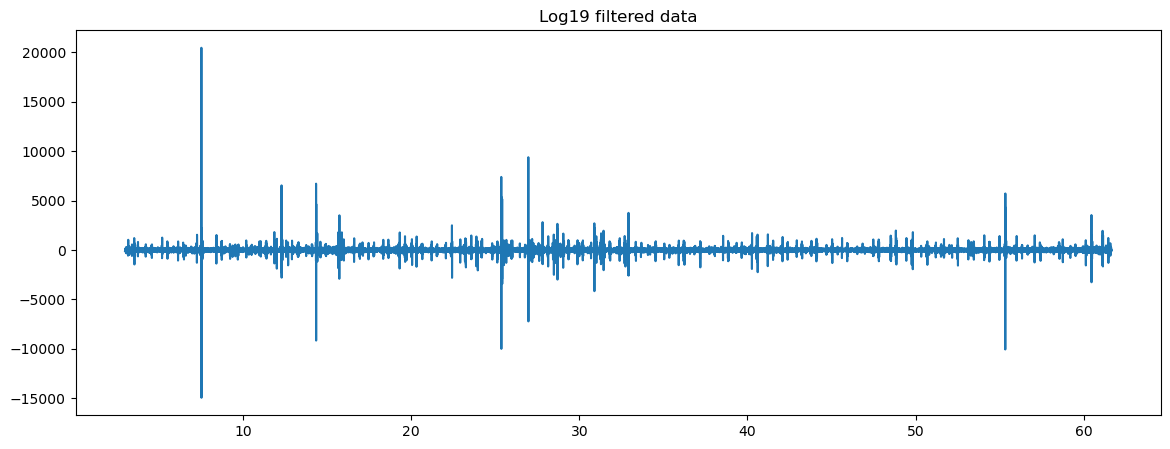

In [137]:
## filtering
# filter data with band pass filter
filtered = bandpass(values, [20, 150], sr)

# remove first 3 seconds of data because large spike from start up
remove_start = filtered[round(3*sr):] 
time = time[round(3*sr):]

# plot filtered data
plt.figure(figsize=(14, 5))
plt.plot(time, remove_start)
plt.title(f"{name} filtered data")

In [ ]:
## write filtered data to desired data type
# write data to csv
with open((name + '.csv'), mode='w') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    writer.writerow(['Time','Amplitude'])
    for n in range(len(time)):
        writer.writerow([time[n],remove_start[n]])

# convert filtered data to wav
csv2mp3(10*remove_start,sr,output_file=(name + "_filtered"))

"with open((name + '.csv'), mode='w') as csv_file:\n    writer = csv.writer(csv_file, delimiter=',')\n    writer.writerow(['Time','Amplitude'])\n    for n in range(len(time)):\n        writer.writerow([time[n],remove_start[n]])"

In [139]:
## flatten large spikes in data to "normal" range
# threshold is the based on standard deviation (if point lands outside threshold*standard deviation, its an outlier)
outlier_threshold = 3 
outliers_flattened = remove_spikes(remove_start,outlier_threshold,sr)

## normalize the data so ampltiude is less arbitrary, then shift so its centered around 0
normalized = 2*normalize_array(outliers_flattened)-1

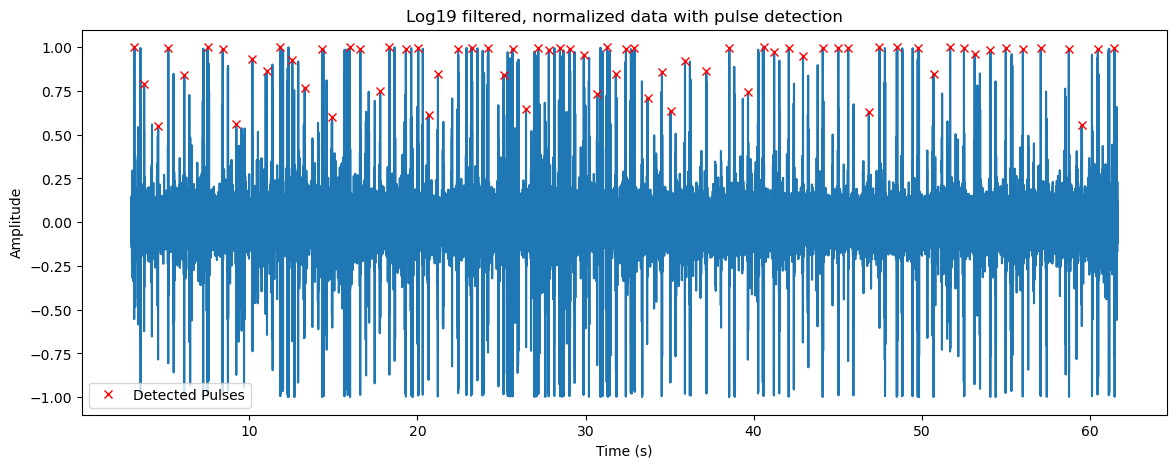

Number of pulses detected: 69
Duration of measurement: 58.68 seconds
Max Heart Rate: 88 bpm
Min Heart Rate: 66 bpm
Average Heart Rate: 76 bpm
Calculated heart rate: 71 bpm


In [ ]:
## pulse detection, heart rate calculations for filtered, normalized data
# get all peaks
raw_peaks, _ = find_peaks(normalized, height=0)

# get mean amplitude and threshold value for noise
mean_amp = np.mean(normalized[raw_peaks])
noise_threshold = mean_amp

# find pulse peaks
peaks, _ = find_peaks(normalized, height=noise_threshold, distance=sr*0.5,prominence=1)# tune prominence per human ;-;
# just for snr calculation
mean_pulse_amp = np.mean(normalized[peaks])

# define starting and end times, and duration
start = time[peaks[0]]
end = time[peaks[-1]]
duration = time[-1] - time[0]

# plot data
plt.figure(figsize=(14, 5))
plt.plot(time, normalized)
plt.plot(time[peaks], normalized[peaks], "rx", label="Detected Pulses")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"{name} filtered, normalized data with pulse detection")
plt.legend(loc='lower left')
plt.savefig(name +'.png')
plt.show()

# display number of pulses detected and duration of measurement
print(f"Number of pulses detected: {len(peaks)}")
print(f"Duration of measurement: {duration:.2f} seconds")

# calculate time difference between peaks, get frequencies and calculate values
peak_times = time[peaks]
peak_intervals = np.diff(peak_times)
frequencies = 1/peak_intervals

# get average frequency over n beats
n = 20
avg_freq_n_beats = []

for value in range(len(frequencies)-n):
    avg_value = np.mean(frequencies[value:value+n])
    avg_freq_n_beats.append(avg_value)

# calculate max, min and display if avg over n is not empty
if len(avg_freq_n_beats) > 0:
    max_heartrate = np.max(avg_freq_n_beats)*60
    min_heartrate = np.min(avg_freq_n_beats)*60
    print(f"Max Heart Rate: {round(max_heartrate)} bpm")
    print(f"Min Heart Rate: {round(min_heartrate)} bpm")

# calculate average heartrate
avg_heartrate = np.mean(frequencies)*60
print(f"Average Heart Rate: {round(avg_heartrate)} bpm")

calc_heartrate = len(peaks)/(end-start)*60 # ideally end-start is just length of the sound sample
print(f"Calculated heart rate: {round(calc_heartrate)} bpm")